Grating shape: (1000, 3095, 2)
Delta array shape: (1000,)
Running SHG analysis...
Power array shape: (1000, 1000)


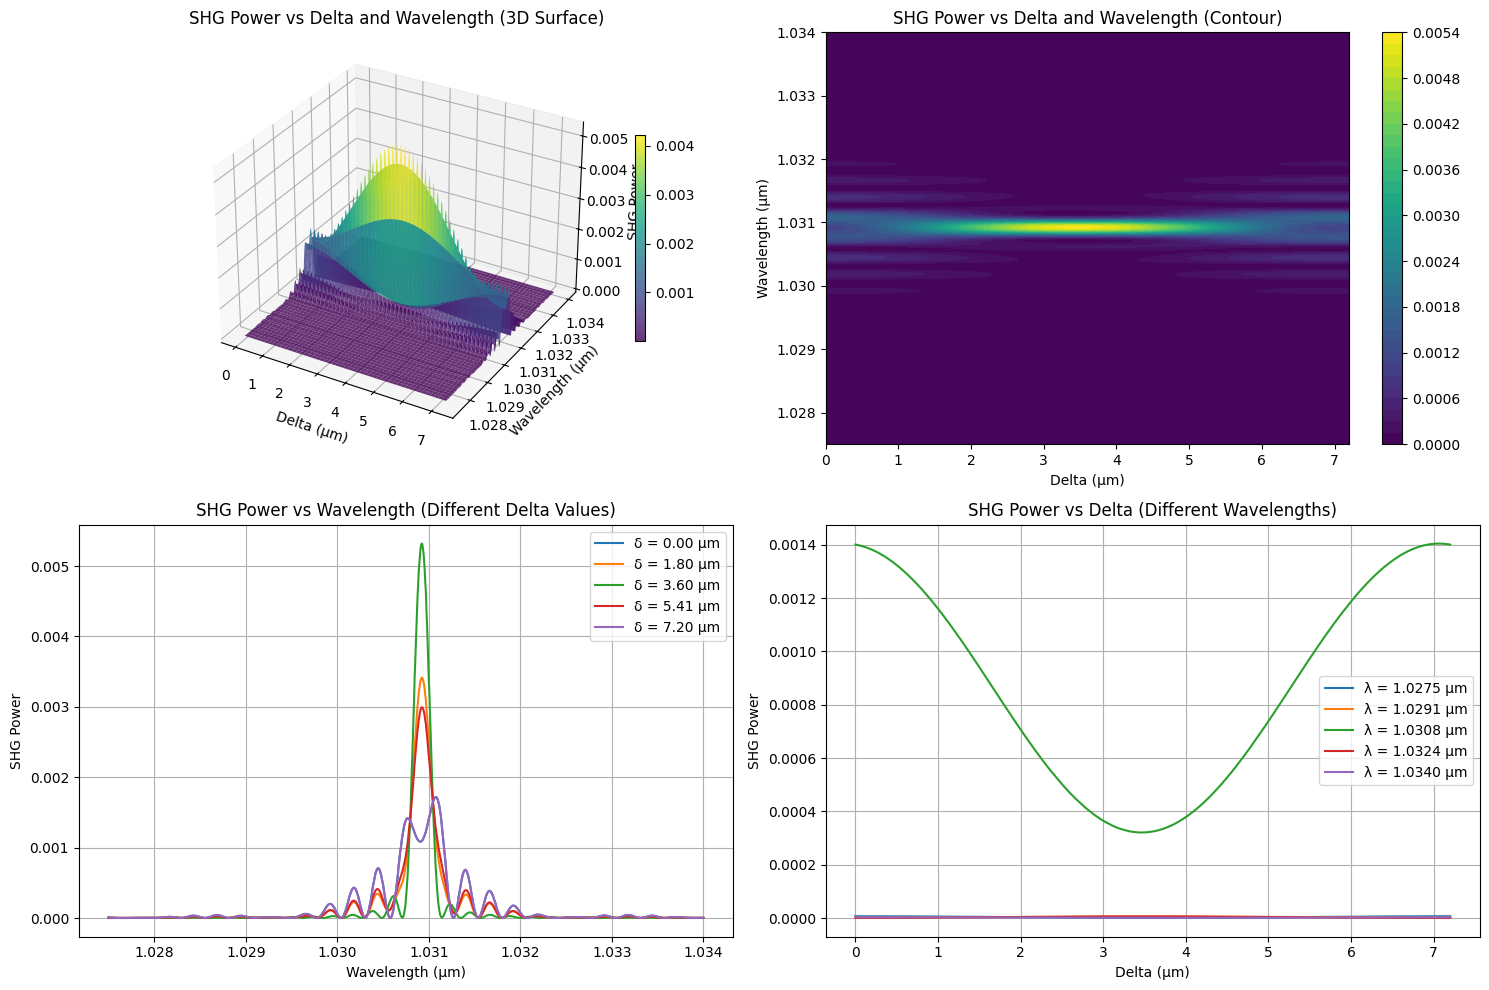


Maximum SHG Power Analysis:
Maximum Power: 0.005331
Optimal Delta: 3.495 µm
Optimal Wavelength: 1.0309 µm


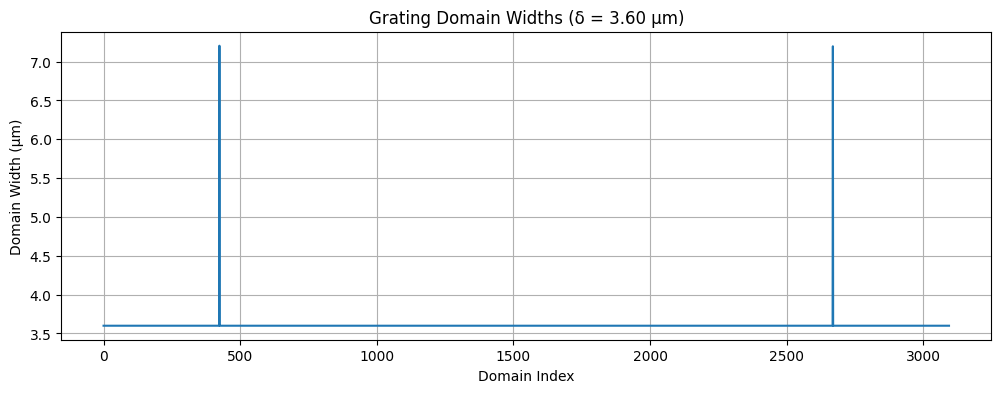

In [7]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
from typing import List
import numpy as np


# ---------------------------------------------------------------------------
# Simulation Settings
# ---------------------------------------------------------------------------
Lambda = 7.2
num_domains = 1000
kappa = 1.031E-05
wavelengths_list = jnp.linspace(1.0275, 1.034, 1000).tolist()
T_dim: List[float] = [20]

# Create delta array for parallel computation (0 to 7.2, 1000 divisions)
delta_array = jnp.linspace(0, 7.2, 1000)

# Define grating components with period_dim for parallel computation
# All components need to have the same shape for concatenation

# Grating 1: 424 domains
grating1 = pp.periodical(
    num_domains=424,
    period_dim=[Lambda] * len(delta_array),  # Same Lambda for all delta values
    kappa_val=kappa,
    duty=1/2
)

# Offset domain 1: width varies with delta
offset_widths1 = [Lambda/2 + delta for delta in delta_array]
offset_domain1 = pp.fixed(
    num_domains=1,
    width_dim=offset_widths1,  # Different width for each delta
    kappa_val=kappa
)

# Grating 2: 2244 domains
grating2 = pp.periodical(
    num_domains=2244,
    period_dim=[Lambda] * len(delta_array),  # Same Lambda for all delta values
    kappa_val=kappa,
    duty=1/2
)

# Offset domain 2: width varies with delta
offset_widths2 = [Lambda/2 + Lambda - delta for delta in delta_array]
offset_domain2 = pp.fixed(
    num_domains=1,
    width_dim=offset_widths2,  # Different width for each delta
    kappa_val=kappa
)

# Grating 3: 425 domains
grating3 = pp.periodical(
    num_domains=425,
    period_dim=[Lambda] * len(delta_array),  # Same Lambda for all delta values
    kappa_val=kappa,
    duty=1/2
)

# Concatenate the grating components to form the full grating structure
grating = pp.concatenate(
    [grating1, offset_domain1, grating2, offset_domain2, grating3]
)

print(f"Grating shape: {grating.shape}")
print(f"Delta array shape: {delta_array.shape}")

# SHG simulation parameters with parallel computation over delta values
shg_params = shg.Params(
    grating_dim=grating,
    T_dim=70,
    wavelength_dim=wavelengths_list,
    fund_power_dim=1,
    sh_power_dim=0
)

# Analyze SHG - this will compute for all delta values in parallel
print("Running SHG analysis...")
eff_tensor = shg.analyze(shg_params, mgoslt.use_material, shg.solve_ncme)

# Extract SHG power
# eff_tensor shape: (1000, 1, 1000, 1, 1) = (delta, ?, wavelength, ?, ?)
eff_complex = eff_tensor[:, 0, :, 0, 0]  # [delta_index, wavelength_index]
power = jnp.abs(eff_complex)**2

print(f"Power array shape: {power.shape}")

# ---------------------------------------------------------------------------
# 3D Plot
# ---------------------------------------------------------------------------

# Create meshgrid for 3D plotting
Delta_mesh, Wavelength_mesh = jnp.meshgrid(
    delta_array, jnp.array(wavelengths_list), indexing='ij')

# Create 3D plot
fig = plt.figure(figsize=(15, 10))

# 3D Surface Plot
ax1 = fig.add_subplot(221, projection='3d')
surf = ax1.plot_surface(Delta_mesh, Wavelength_mesh, power,  # type: ignore
                        cmap='viridis', alpha=0.8)
ax1.set_xlabel('Delta (µm)')
ax1.set_ylabel('Wavelength (µm)')
ax1.set_zlabel('SHG Power')  # type: ignore
ax1.set_title('SHG Power vs Delta and Wavelength (3D Surface)')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# 2D Contour Plot
ax2 = fig.add_subplot(222)
contour = ax2.contourf(Delta_mesh, Wavelength_mesh,
                       power, levels=50, cmap='viridis')
ax2.set_xlabel('Delta (µm)')
ax2.set_ylabel('Wavelength (µm)')
ax2.set_title('SHG Power vs Delta and Wavelength (Contour)')
fig.colorbar(contour, ax=ax2)

# Cross-section at specific delta values
ax3 = fig.add_subplot(223)
delta_indices = [0, 250, 500, 750, 999]  # Sample different delta values
for idx in delta_indices:
    ax3.plot(wavelengths_list, power[idx, :],
             label=f'δ = {delta_array[idx]:.2f} µm')
ax3.set_xlabel('Wavelength (µm)')
ax3.set_ylabel('SHG Power')
ax3.set_title('SHG Power vs Wavelength (Different Delta Values)')
ax3.legend()
ax3.grid(True)

# Cross-section at specific wavelength values
ax4 = fig.add_subplot(224)
wavelength_indices = [0, 250, 500, 750, 999]  # Sample different wavelengths
for idx in wavelength_indices:
    ax4.plot(delta_array, power[:, idx],
             label=f'λ = {wavelengths_list[idx]:.4f} µm')
ax4.set_xlabel('Delta (µm)')
ax4.set_ylabel('SHG Power')
ax4.set_title('SHG Power vs Delta (Different Wavelengths)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Additional Analysis
# ---------------------------------------------------------------------------

# Find maximum power and its corresponding delta and wavelength
max_power_idx = jnp.unravel_index(jnp.argmax(power), power.shape)
max_delta = delta_array[max_power_idx[0]]
max_wavelength = wavelengths_list[max_power_idx[1]]
max_power_value = power[max_power_idx]

print(f"\nMaximum SHG Power Analysis:")
print(f"Maximum Power: {max_power_value:.6f}")
print(f"Optimal Delta: {max_delta:.3f} µm")
print(f"Optimal Wavelength: {max_wavelength:.4f} µm")

# Show grating structure for a specific delta value (middle value)
middle_delta_idx = len(delta_array) // 2
grating_widths = grating[middle_delta_idx, :, 0]
x_axis_grating = np.arange(len(grating_widths))

plt.figure(figsize=(12, 4))
plt.plot(x_axis_grating, grating_widths)
plt.xlabel('Domain Index')
plt.ylabel('Domain Width (µm)')
plt.title(
    f'Grating Domain Widths (δ = {delta_array[middle_delta_idx]:.2f} µm)')
plt.grid(True)
plt.show()

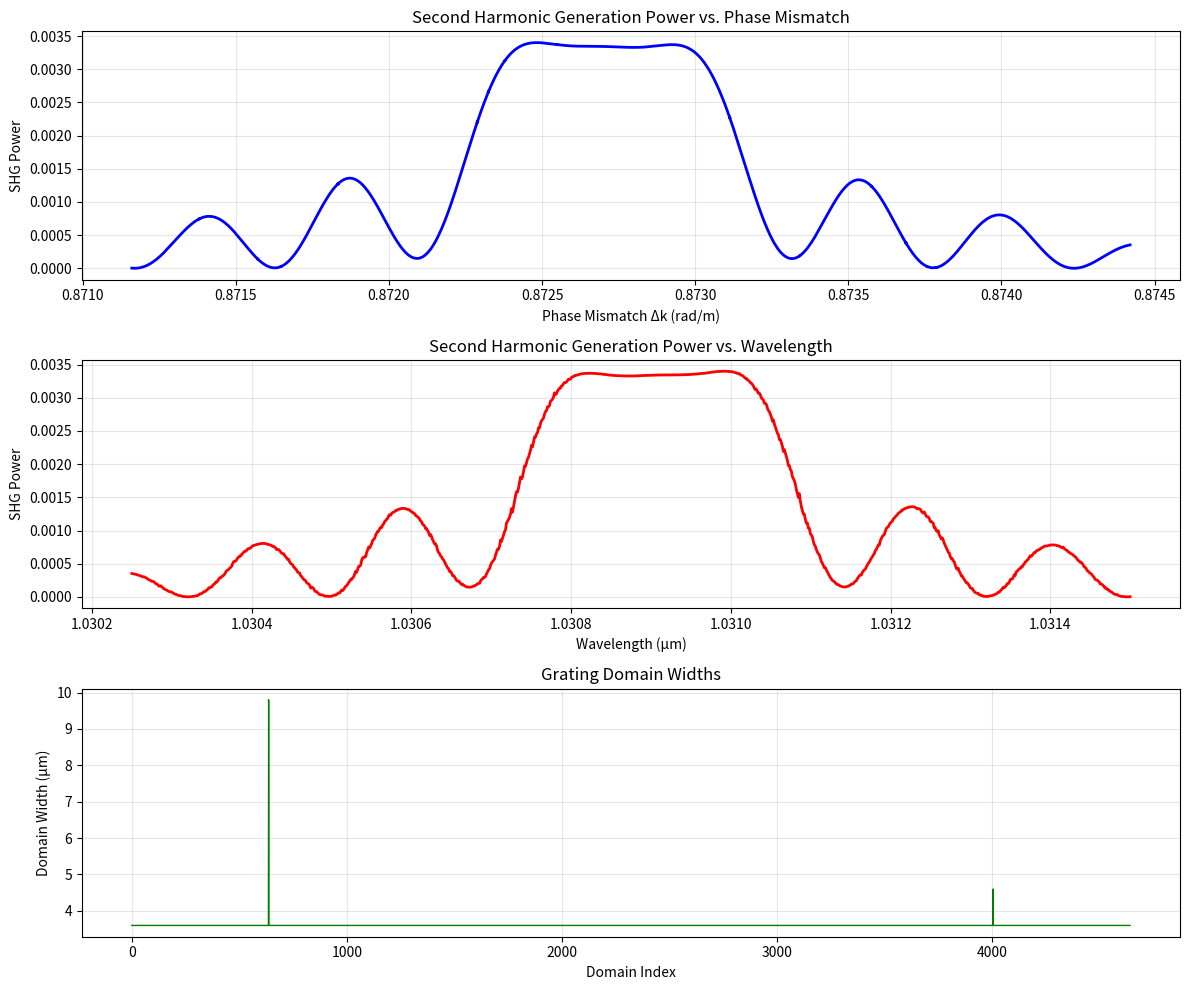

In [17]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
from typing import List
import numpy as np


Lambda = 7.2
delta = 6.2
kappa = 1.031E-05
wavelengths_list = jnp.linspace(1.03025, 1.0315, 1000).tolist()
T_dim: List[float] = [20]

grating1 = pp.periodical(num_domains=int(424*1.5), period_dim=[
    Lambda], kappa_val=kappa, duty=1/2)
offset_domain1 = pp.fixed(num_domains=1, width_dim=[
    Lambda/2 + delta], kappa_val=kappa)
grating2 = pp.periodical(num_domains=int(2244*1.5), period_dim=[
    Lambda], kappa_val=kappa, duty=1/2)
offset_domain2 = pp.fixed(num_domains=1, width_dim=[
    Lambda/2 + Lambda - delta], kappa_val=kappa)
grating3 = pp.periodical(num_domains=int(425*1.5), period_dim=[
    Lambda], kappa_val=kappa, duty=1/2)

grating = pp.concatenate(
    [grating1, offset_domain1, grating2, offset_domain2, grating3])

grating_widths = grating[0, :, 0]
x_axis_grating = np.arange(len(grating_widths))

shg_params = shg.Params(
    grating_dim=grating,
    T_dim=70, wavelength_dim=wavelengths_list,
    fund_power_dim=1, sh_power_dim=0
)

eff_tensor = shg.analyze(shg_params, mgoslt.use_material, shg.solve_ncme)

eff_complex = eff_tensor[0, 0, :, 0, 0]
power = jnp.abs(eff_complex)**2

# 位相不整合を計算
phase_mismatch = mgoslt.use_material(
    jnp.array(wavelengths_list), jnp.array([70]))
phase_mismatch_value = phase_mismatch(1)
delta_k = phase_mismatch_value.squeeze()  # shape: (1000,)

plt.figure(figsize=(12, 10))

# 1. 位相不整合 vs SHG効率
plt.subplot(3, 1, 1)
plt.plot(delta_k, power, 'b-', linewidth=2)
plt.xlabel('Phase Mismatch Δk (rad/m)')
plt.ylabel('SHG Power')
plt.title('Second Harmonic Generation Power vs. Phase Mismatch')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(wavelengths_list, power, 'r-', linewidth=2)
plt.xlabel('Wavelength (µm)')
plt.ylabel('SHG Power')
plt.title('Second Harmonic Generation Power vs. Wavelength')
plt.grid(True, alpha=0.3)

# 3. グレーティング構造
plt.subplot(3, 1, 3)
plt.plot(x_axis_grating, grating_widths, 'g-', linewidth=1)
plt.xlabel('Domain Index')
plt.ylabel('Domain Width (µm)')
plt.title('Grating Domain Widths')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()